In [15]:
import pandas as pd

# Cargar el dataset
df = pd.read_csv("/Users/Usuario/Documents/CUARTO AÑO/DATA SCIENCE/Proyecto final/synthetic_fraud_dataset 2.csv")  # Reemplaza con la ruta correcta si aplica

# Copia del dataset original
df_clean = df.copy()

# Eliminar columnas no predictivas
df_clean.drop(columns=['Transaction_ID', 'User_ID'], inplace=True)

# Convertir 'Timestamp' a datetime y extraer información útil
df_clean['Timestamp'] = pd.to_datetime(df_clean['Timestamp'], errors='coerce')
df_clean['Hour'] = df_clean['Timestamp'].dt.hour
df_clean['DayOfWeek'] = df_clean['Timestamp'].dt.dayofweek
df_clean.drop(columns=['Timestamp'], inplace=True)

# Variables categóricas para codificación
categorical_cols = [
    'Transaction_Type', 'Device_Type', 'Location',
    'Merchant_Category', 'Card_Type', 'Authentication_Method'
]

# Aplicar One-Hot Encoding
df_encoded = pd.get_dummies(df_clean, columns=categorical_cols, drop_first=True)

# Mostrar los primeros registros del dataset procesado
df_encoded.head()


,Transaction_Amount,Account_Balance,IP_Address_Flag,Previous_Fraudulent_Activity,Daily_Transaction_Count,Avg_Transaction_Amount_7d,Failed_Transaction_Count_7d,Card_Age,Transaction_Distance,Risk_Score,...,Merchant_Category_Electronics,Merchant_Category_Groceries,Merchant_Category_Restaurants,Merchant_Category_Travel,Card_Type_Discover,Card_Type_Mastercard,Card_Type_Visa,Authentication_Method_OTP,Authentication_Method_PIN,Authentication_Method_Password
0,39.79,93213.17,0,0,7,437.63,3,65,883.17,0.8494,...,False,False,False,True,False,False,False,False,False,False
1,1.19,75725.25,0,0,13,478.76,4,186,2203.36,0.0959,...,False,False,False,False,False,True,False,False,False,True
2,28.96,1588.96,0,0,14,50.01,4,226,1909.29,0.8400,...,False,False,True,False,False,False,True,False,False,False
3,254.32,76807.20,0,0,8,182.48,4,76,1311.86,0.7935,...,False,False,False,False,False,False,True,True,False,False
4,31.28,92354.66,0,1,14,328.69,4,140,966.98,0.3819,...,True,False,False,False,False,True,False,False,False,True


In [16]:
import numpy as np

# Verificar valores nulos
null_counts = df_encoded.isnull().sum()

# Verificar duplicados
duplicated_rows = df_encoded.duplicated().sum()

print(duplicated_rows)
print(null_counts)

0
Transaction_Amount                0
Account_Balance                   0
IP_Address_Flag                   0
Previous_Fraudulent_Activity      0
Daily_Transaction_Count           0
Avg_Transaction_Amount_7d         0
Failed_Transaction_Count_7d       0
Card_Age                          0
Transaction_Distance              0
Risk_Score                        0
Is_Weekend                        0
Fraud_Label                       0
Hour                              0
DayOfWeek                         0
Transaction_Type_Bank Transfer    0
Transaction_Type_Online           0
Transaction_Type_POS              0
Device_Type_Mobile                0
Device_Type_Tablet                0
Location_Mumbai                   0
Location_New York                 0
Location_Sydney                   0
Location_Tokyo                    0
Merchant_Category_Electronics     0
Merchant_Category_Groceries       0
Merchant_Category_Restaurants     0
Merchant_Category_Travel          0
Card_Type_Discover        

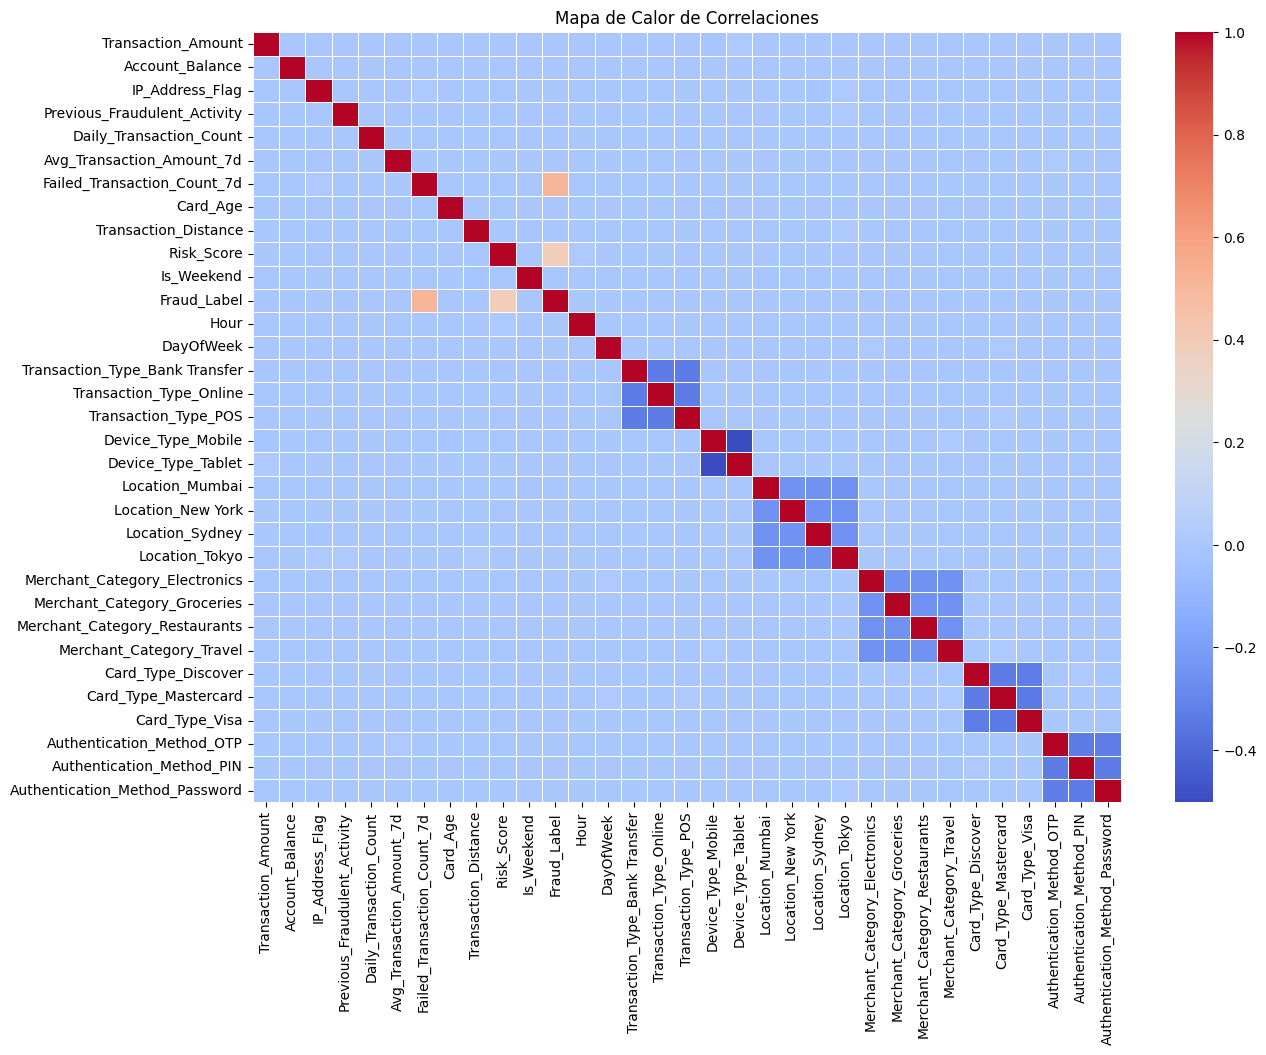

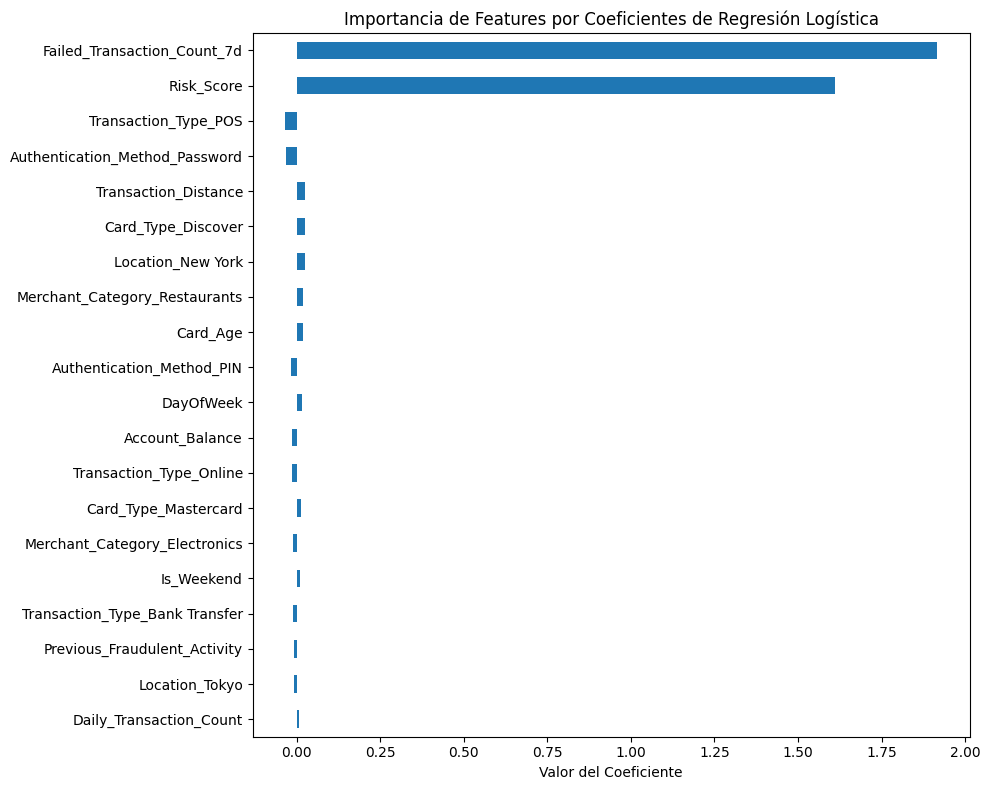

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Remover columna 'Transaction_Type' si está presente (agregada en el EDA)
df_model = df_encoded.copy()
if 'Transaction_Type' in df_model.columns:
    df_model.drop(columns=['Transaction_Type'], inplace=True)

# Separar variables
X = df_model.drop(columns=['Fraud_Label'])
y = df_model['Fraud_Label']

# Escalar para coeficientes
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.2, stratify=y, random_state=42)

# Modelo de regresión logística para coeficientes
model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

# Coeficientes del modelo
coefficients = pd.Series(model.coef_[0], index=X.columns).sort_values(key=abs, ascending=False)

# Mapa de calor de correlaciones
plt.figure(figsize=(14, 10))
sns.heatmap(df_model.corr(), cmap='coolwarm', annot=False, fmt='.2f', linewidths=0.5)
plt.title('Mapa de Calor de Correlaciones')
plt.show()

# Gráfico de importancia por coeficientes
plt.figure(figsize=(10, 8))
coefficients.head(20).plot(kind='barh')
plt.title('Importancia de Features por Coeficientes de Regresión Logística')
plt.xlabel('Valor del Coeficiente')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Mostrar top 15 coeficientes como tabla
top_coefficients = coefficients.head(15).to_frame(name='Coeficiente')


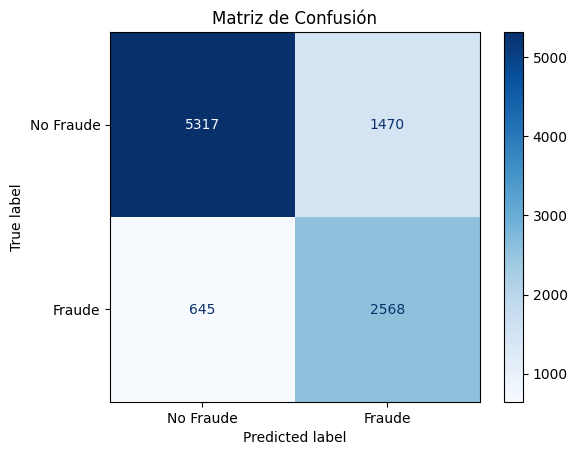

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Usamos las variables seleccionadas por coeficiente para este modelo simple
important_features = ['Risk_Score', 'Failed_Transaction_Count_7d', 'Transaction_Distance']
X = df_model[important_features]
y = df_model['Fraud_Label']

# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Modelo
model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

# Predicciones
y_pred = model.predict(X_test)

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Fraude', 'Fraude'])

# Mostrar gráfica
disp.plot(cmap='Blues')
plt.title('Matriz de Confusión')
plt.show()

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Calcular métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

# Mostrar métricas
metrics_summary = pd.DataFrame({
    'Métrica': ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC AUC'],
    'Valor': [accuracy, precision, recall, f1, roc_auc]
})

metrics_summary


,Métrica,Valor
0,Accuracy,0.788500
1,Precision,0.635958
2,Recall,0.799253
3,F1-score,0.708316
4,ROC AUC,0.890363
